In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from lib.NBA_functions import get_corrs
import warnings
warnings.simplefilter("ignore", UserWarning)

import pandas as pd

In [2]:
from matplotlib import rcParams
import matplotlib as mpl

blue = '#3498DB'
gray = '#95A5A6'
red = '#E74C3C'
dark_gray = '#34495E'
green = '#2ECC71'
purple = '#9B59B6'
flatui = [blue, gray, red, dark_gray, green, purple]

# Patches
mpl.rc('patch', 
       linewidth=0.5, 
       facecolor=dark_gray, 
       edgecolor='w', 
       force_edgecolor=True, 
       antialiased=True)    
  
# Figure
mpl.rc('figure', 
       figsize= (10, 6),
       facecolor='w', 
       edgecolor='w', 
       titlesize='xx-large',
       titleweight=700)

# Grid
mpl.rc('grid', 
       color=dark_gray,
       alpha=0.5, 
       linewidth=0.5, 
       linestyle='-')

# Axes
mpl.rc('axes', 
       facecolor='w',
       edgecolor=dark_gray,
       linewidth=0.5,
       grid=True,
       titlesize='large',
       labelsize='large',
       labelcolor=dark_gray,
       axisbelow=True)

mpl.rc('axes.spines',
       right=False,
       top=False)

# Ticks
mpl.rc('xtick', 
       direction='out',
       color=dark_gray)

mpl.rc('xtick.major', 
       size=0.0)

mpl.rc('xtick.minor', 
       size=0.0)

mpl.rc('ytick', 
       direction='out',
       color=dark_gray)

mpl.rc('ytick.major', 
       size=0.0)

mpl.rc('ytick.minor', 
       size=0.0)

mpl.rc('legend', 
       frameon=False,
       numpoints=1,
       scatterpoints=1)

mpl.rc('font', 
       size=13,
       weight=400,
       family='sans-serif')

rcParams['font.sans-serif']: ['Helvetica', 'Verdana', 'Lucida Grande']

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

In [3]:
teams = pd.read_csv("data/teams.csv", sep = '\t')
teams = teams.drop(columns = 'Unnamed: 0')

In [4]:
# two years (1998 and 2011) had truncated seasons that can/will affect full seasons stats 
# 'teamsf' will be every full season

teamsf = teams[(teams.Year != 1998) & (teams.Year != 2011)]

In [5]:
top = teamsf[teamsf['Rank'] <= 4]
mid = teamsf[(teamsf['Rank'] < 9) & (teamsf['Rank'] > 4)]

made = teamsf[teamsf['Playoffs'] == 1]
missed = teamsf[teamsf['Playoffs'] == 0]

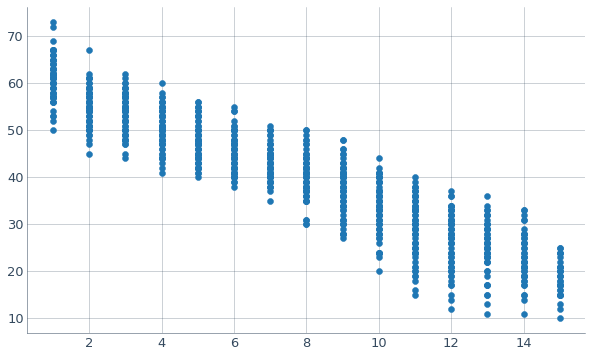

In [7]:
plt.scatter(x = teamsf['Rank'], y = teamsf['W'])
plt.show()

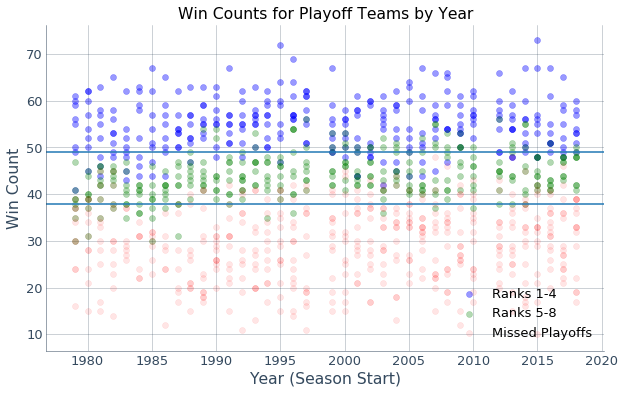

In [8]:
plt.scatter(x = top['Year'], y = top['W'], color = 'b', alpha = 0.4)
plt.scatter(x = mid['Year'], y = mid['W'], color = 'g', alpha = 0.3)
plt.scatter(x = missed['Year'], y = missed['W'], color = 'r', alpha = 0.1)
plt.xlabel('Year (Season Start)')
plt.ylabel('Win Count')
plt.title('Win Counts for Playoff Teams by Year')
plt.legend(['Ranks 1-4','Ranks 5-8','Missed Playoffs'], loc = 'lower right')
plt.axhline(38) # seemingly, the low end threshold for playoff teams
plt.axhline(49) # seemingly, the threshold for premium rank (1-4)
#plt.savefig('win-loss.png')
plt.show()

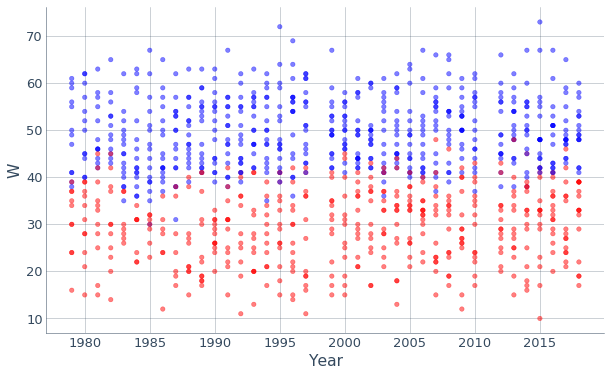

In [9]:
colors = {1: 'blue', 0: 'red'}
teamsf.plot.scatter('Year', 'W', c=teamsf.Playoffs.map(colors), alpha = 0.5);

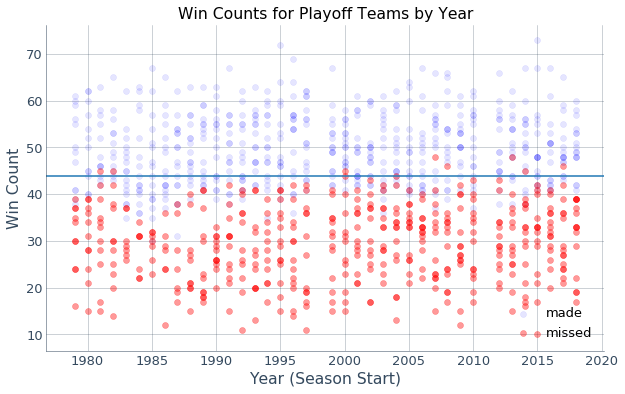

In [10]:
plt.scatter(x = made['Year'], y = made['W'], color = 'b', alpha = 0.1)
plt.scatter(x = missed['Year'], y = missed['W'], color = 'r', alpha = 0.4)
plt.xlabel('Year (Season Start)')
plt.ylabel('Win Count')
plt.title('Win Counts for Playoff Teams by Year')
plt.legend(['made','missed'], loc = 'lower right')
plt.axhline(44)
plt.show()

In [11]:
made_list = []
missed_list = []
wins = range(15,68)
for count in wins:
    over = teamsf[teamsf['W'] == count]
    #under = conditions(teams['W'] < count, data = teams)
    po_teams = over[over['Playoffs']==1]
    make = len(po_teams)/len(over)
    miss = 1 - make
    made_list.append(make)
    missed_list.append(miss)
    
chance_df = pd.DataFrame({'win count': wins,
                          'made chance' : made_list,
                          'missed chance' : missed_list})



In [12]:
# logistic regression

# subset df with features of interest

logdf = teamsf[['W','Playoffs']]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(logdf.drop('Playoffs',axis=1), 
                                                    logdf['Playoffs'], test_size=0.30, 
                                                    random_state=23)
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression(solver = 'lbfgs')
logmodel.fit(X_train,y_train)
predictions = logmodel.predict(X_test)

from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, predictions)
print("Confusion Matrix : ")
print(confusion_matrix)

print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logmodel.score(X_test, y_test)))

Confusion Matrix : 
[[120  12]
 [ 10 177]]
Accuracy of logistic regression classifier on test set: 0.93


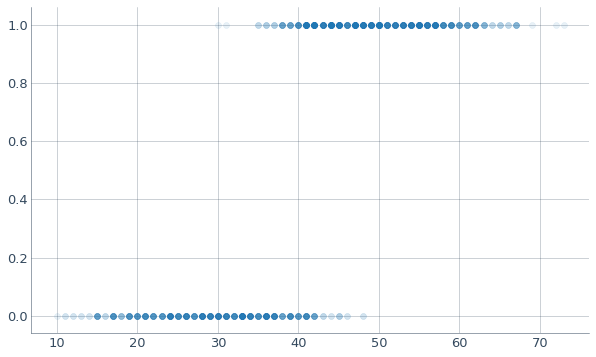

In [13]:
# logistic regression

from sklearn import linear_model
from scipy.special import expit

X = teamsf['W'].values
y = teamsf['Playoffs']

plt.scatter(X, y, alpha = 0.1)
plt.show()


This is where professional basketball starts to deviate from the Moneyball approach. While we have our win-total goal (let's call it 44 wins), the next step isn't nearly as straightforward. See, what ought to logically follow is the question of "well, how many points would get you 44 wins?" As the plot below should illuminate, there isn't an obvious answer.  While teams with 44+ wins typically make the playoffs, their season totals for points can range anywhere from 7,500 to 10,500.

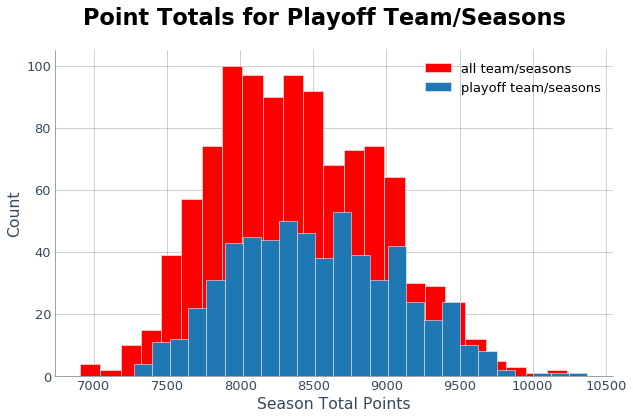

In [14]:
plt.hist(teamsf['PS'], bins = 25, color = 'r')
plt.hist(made['PS'], bins = 25)
plt.xlabel('Season Total Points')
plt.ylabel('Count')
plt.suptitle('Point Totals for Playoff Team/Seasons')
plt.legend({'all team/seasons': 'r',
            'playoff team/seasons': 'b'})
plt.show()

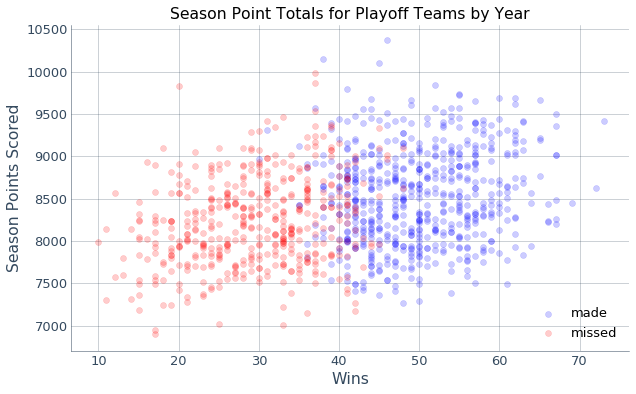

In [15]:
plt.scatter(x = made['W'], y = made['PS'], color = 'b', alpha = 0.2)
plt.scatter(x = missed['W'], y = missed['PS'], color = 'r', alpha = 0.2)
plt.xlabel('Wins')
plt.ylabel('Season Points Scored')
plt.title('Season Point Totals for Playoff Teams by Year')
plt.legend(['made','missed'], loc = 'lower right')
plt.show()

Thankfully, as is the case in Moneyball, 'Run Difference', or in this case 'Points Difference', still correlates very strongly with 'W', or 'win count'--as should be intuitive to anyone. When we plot these two things, we see that their relationship is clearly linear and the correlation strong.

In [16]:
x = teamsf['W']
y = teamsf['PD']

print("Correlation between Points Differential and Wins:",x.corr(y))

Correlation between Points Differential and Wins: 0.9703501306055277


Slope :  29.03
-1190.631086151869


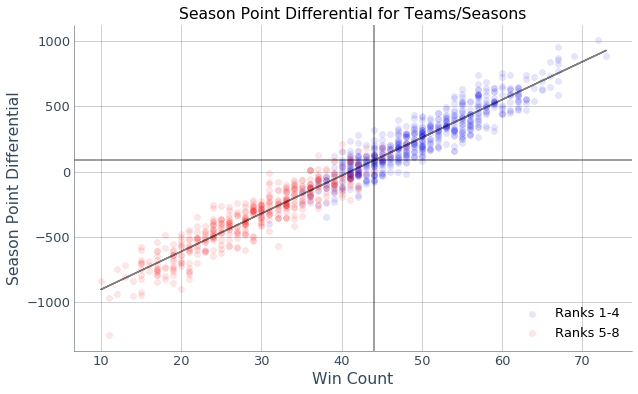

In [17]:
# Deriving slope,intercept values
slope, intercept = np.polyfit(x, y, 1)
abline_values = [slope * i + intercept for i in x]

print('Slope : ', round(slope, 2))
print(intercept)

plt.scatter(x = made['W'], y = made['PD'], color = 'b', alpha = 0.1)
#plt.scatter(x = mid['W'], y = mid['PD'], color = 'g', alpha = 0.1)
plt.scatter(x = missed['W'], y = missed['PD'], color = 'r', alpha = 0.1)
plt.xlabel('Win Count')
plt.ylabel('Season Point Differential')
plt.title('Season Point Differential for Teams/Seasons')
plt.legend(['Ranks 1-4','Ranks 5-8','Missed Playoffs'], loc = 'lower right')
plt.axvline(44, color = 'k', alpha = 0.5)
plt.axhline(87, color = 'k', alpha = 0.5)
plt.plot(x, abline_values, 'k', alpha = 0.5)
plt.show()

In [18]:
win_goal = 44

print(round(slope * win_goal + intercept,3))

print("To achieve at least 44 wins, a team will need a season point differential of at least:", 
      int(round(slope * win_goal + intercept,0)), "points.")

86.907
To achieve at least 44 wins, a team will need a season point differential of at least: 87 points.


When we create a simple ab-line, we see that, on average, every additional win is a season point-difference of roughly 27-28 points. Nicely, this approximation puts our win goal of 44 wins at 87 (86.968) points over oppenents for the season.

The next step is to find which team stats correlate the strongest with wins. Below is a series of correlation values for the top 10 features with wins:

In [19]:
wins_corr = teams.corr().iloc[1,:]
wins_corr.sort_values(ascending = False)[:10]

W           1.000000
W/L%        0.972353
PD          0.945841
PD/G        0.943825
Playoffs    0.780411
2P%         0.549044
FG%         0.496253
PS          0.365560
PS/G        0.359510
DRB         0.351432
Name: W, dtype: float64

Initially, this seems satisfactory, but a few things ought to be noticed, importantly: 1) The first 5 features tell us nothing--of course W/L% correlates well with wins; of course making the playoffs correlates strongly with winning games; that's what defines making the playoffs. 2) This list of correlation values is drawn from a data set of team seasons from the past 40 years. The NBA game has changed more than once in that time, in rule changes, in league size, and in style of play. To demonstrate this second point, let's look at top correlates from date ranges other than just from 1979 to today. For example, we could look at correlations with winning dating back to just 2001, what some would call the "modern era" of basketball. Below is that code worked out:

In [20]:
headers = list(range(min(teams['Year']),max(teams['Year']),5))

# we can use 5 year steps here just to give us more data points, but 5 is itself arbitrary. The game
# has shifted (either by rule changes or in styles) approximately every 10 years, so 10 would work here
# as well

headers

[1979, 1984, 1989, 1994, 1999, 2004, 2009, 2014]

In [21]:
# we'll call this df 'wc' for 'win correlates'

wc = get_corrs('W')

# drop columns we know will correlate strongly or obviously not at all (e.g. 'Year' and 'Rank')
wc = wc.drop(labels = ['Year','L', 'W/L%','Rank','Playoffs','PD','PD/G','Games'])

wc.sort_values(1999, ascending = False)

,1979,1984,1989,1994,1999,2004,2009,2014
W,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
FG%,0.496253,0.531898,0.580909,0.612629,0.583932,0.614892,0.655877,0.628395
2P%,0.549044,0.553734,0.551414,0.533290,0.481850,0.544316,0.588811,0.564988
3P%,0.176506,0.283294,0.382144,0.484910,0.475450,0.517208,0.552217,0.582891
AST,0.346759,0.351778,0.384742,0.414625,0.372257,0.350426,0.377897,0.407802
PS/G,0.359510,0.374254,0.395845,0.412149,0.368300,0.401427,0.451380,0.473315
PS,0.365560,0.377180,0.390721,0.408962,0.360020,0.369821,0.391532,0.473315
DRB,0.351432,0.350044,0.345767,0.339679,0.342818,0.340369,0.372786,0.390193
FG,0.250904,0.270121,0.302446,0.352060,0.311527,0.325700,0.388267,0.426982
BLK,0.225227,0.200370,0.187690,0.176649,0.257318,0.283755,0.278407,0.342010


            2
-0.0003211 x + 1.293 x - 1301


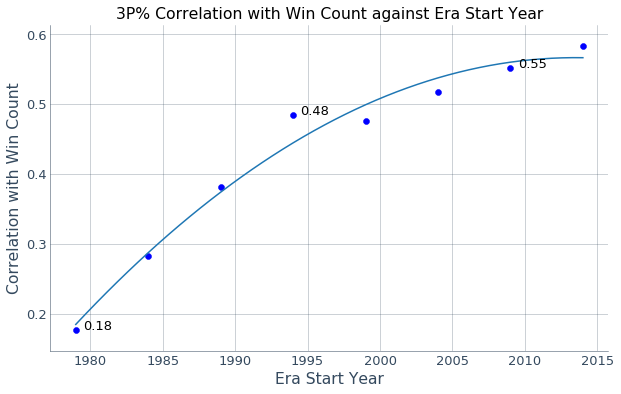

In [22]:
stat = '3P%'
corr1 = wc.loc[stat,1979]
corr2 = wc.loc[stat,1994]
corr3 = wc.loc[stat,2009]
x = wc.columns
y = wc.loc[stat,:]

plt.scatter(x = x, y = y, color = 'b')
plt.text(x = 1979 + 0.5, y = corr1, s = round(corr1, 2))
plt.text(x = 1994 + 0.5, y = corr2, s = round(corr2, 2))
plt.text(x = 2009 + 0.5, y = corr3, s = round(corr3, 2))

# calculate polynomial
z = np.polyfit(x, y, 2)
f = np.poly1d(z)
print(f)

# calculate new x's and y's
x_new = np.linspace(x[0], x[-1], 50)
y_new = f(x_new)

plt.plot(x_new, y_new)
plt.ylabel('Correlation with Win Count')
plt.xlabel('Era Start Year')
plt.title(str(stat) + ' Correlation with Win Count against Era Start Year')
plt.show()

The above plot demonstrates my concern beautifully: if we were to look at all the data, dating back to 1979, 3P% would correlate with win count at about 0.18. But if we look at data from 1994 onward, it correlates at 0.48 , at 0.55 if we just chose to look at the last 10 years (and higher still in the last 5 years). Lesson? The 3-point shot has become more and more important over the last 40 years.

As far as a line of best fit goes, standard models won't apply for different reasons. A straight linear model makes sense for this data (and fits nicely), but would ultimately result in a correlation of over 1.0 in the next 40-50 years, which is nonsense. A second-degree polynomial fits just as well if not better, but has a negative coefficient for x-squared. This would result in the trend being undone in the opposite direction across the next 40 years. A third-degree polynomial has the same problem as our first degree--it would produce over 1.0 correlations in the future. The model that will most likely be the best for predicting future correlations has a horizontal asymptote somewhere between 0.55 and 0.65.

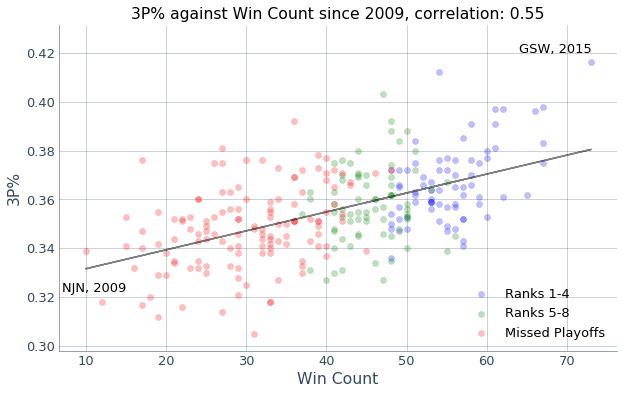

In [23]:
topnew = teamsf[(teamsf['Year'] >= 2009) & (teamsf['Rank'] <= 4)]
midnew = teamsf[(teamsf['Year'] >= 2009) & (teamsf['Rank'] > 4) & (teams['Rank'] < 9)]
missnew = teamsf[(teamsf['Year'] >= 2009) & (teamsf['Rank'] >= 9)]

# Deriving slope,intercept values
x = teamsf[teamsf['Year'] >= 2009]['W']
y = teamsf[teamsf['Year'] >= 2009]['3P%']
slope, intercept = np.polyfit(x, y, 1)
abline_values = [slope * i + intercept for i in x]

plt.scatter(x = topnew['W'], y = topnew[stat], color = 'b', alpha = 0.25)
plt.scatter(x = midnew['W'], y = midnew[stat], color = 'g', alpha = 0.25)
plt.scatter(x = missnew['W'], y = missnew[stat], color = 'r', alpha = 0.25)
plt.legend(['Ranks 1-4','Ranks 5-8','Missed Playoffs'], loc = 'lower right')
plt.plot(x, abline_values, 'k', alpha = 0.5)
plt.text(x = 64, y = 0.42, s = 'GSW, 2015')
plt.text(x = 7, y = 0.322, s = 'NJN, 2009')
plt.xlabel('Win Count')
plt.ylabel(str(stat))
plt.title(str(stat) + " against Win Count since 2009, correlation: " + str(round(corr3,2)))
plt.show()

Seeing a correlation as high as 0.5+ makes me want to set the bar there. With the caveat that we manipulate the start year to find it, what other team stats correlate at least that strongly with win count (W)?

It's important to remember that some of these stats ought to decrease with increased win count (i.e. have a negative correlation) such as, more obviously, loss count (L) and, less obviously, turnovers (TOV). For that reason we ought to look at the absolute value of all correlations. In other words, a strong negative correlation is just as valuable to us a strong positive one.

In [24]:
# set a floor to our correlation value : k

k = 0.4

# highlight every value that is either greater than k or less than -k

wc.style.apply(lambda x: ["background: yellow" if v > k or v < -k else "" for v in x], axis = 1)


,1979,1984,1989,1994,1999,2004,2009,2014
W,1,1,1,1,1,1,1,1
PS/G,0.35951,0.374254,0.395845,0.412149,0.3683,0.401427,0.45138,0.473315
PA/G,-0.259933,-0.274792,-0.309581,-0.31185,-0.359696,-0.363468,-0.309061,-0.36232
PS,0.36556,0.37718,0.390721,0.408962,0.36002,0.369821,0.391532,0.473315
PA,-0.0350019,-0.0248047,-0.0135366,0.0241736,-0.202052,-0.161991,-0.073441,-0.36232
FG,0.250904,0.270121,0.302446,0.35206,0.311527,0.3257,0.388267,0.426982
FGA,-0.0282698,-0.0399295,-0.0599671,-0.0521296,-0.0662951,-0.0705838,-0.0656911,0.00203086
FG%,0.496253,0.531898,0.580909,0.612629,0.583932,0.614892,0.655877,0.628395
3P,0.114442,0.147635,0.185976,0.249563,0.225162,0.276643,0.310538,0.357104
3PA,0.073452,0.09971,0.127711,0.176103,0.153222,0.194472,0.218523,0.240791


We see a few things of note:
1. When considering absolute value, points scored ('PS') correlates strong across the board than points against ('PA'), regardless of how far back we look.
2. FG% stays a strong correlate with every year start, but it should be noted that it's simply a product of 3P% and 2P%. Taking 3P% and 2P% as the important features is the better call.
3. Of our 'non-scoring' stats, Assists holds the highest correlations across the board. Compare it to Rebounds (DRB, ORB, and TRB), steals, blocks, and turnovers.

In [25]:
# set a floor to our correlation value : k

k = 0.2

# highlight every value that is either greater than k or less than -k

wc.style.apply(lambda x: ["background: red" if v < k and v > -k else "" for v in x], axis = 1)

,1979,1984,1989,1994,1999,2004,2009,2014
W,1,1,1,1,1,1,1,1
PS/G,0.35951,0.374254,0.395845,0.412149,0.3683,0.401427,0.45138,0.473315
PA/G,-0.259933,-0.274792,-0.309581,-0.31185,-0.359696,-0.363468,-0.309061,-0.36232
PS,0.36556,0.37718,0.390721,0.408962,0.36002,0.369821,0.391532,0.473315
PA,-0.0350019,-0.0248047,-0.0135366,0.0241736,-0.202052,-0.161991,-0.073441,-0.36232
FG,0.250904,0.270121,0.302446,0.35206,0.311527,0.3257,0.388267,0.426982
FGA,-0.0282698,-0.0399295,-0.0599671,-0.0521296,-0.0662951,-0.0705838,-0.0656911,0.00203086
FG%,0.496253,0.531898,0.580909,0.612629,0.583932,0.614892,0.655877,0.628395
3P,0.114442,0.147635,0.185976,0.249563,0.225162,0.276643,0.310538,0.357104
3PA,0.073452,0.09971,0.127711,0.176103,0.153222,0.194472,0.218523,0.240791


Stats that stand out as having only very weak correlations with wins:
1. Offensive rebounds jumps out above everything else. That the correlation is not only super weak, but negative even is very surprising--there's a story here.
2. Our Free Throw related stat correlations are also low. Suggesting it doesn't matter how often you "get to the line" or even how well you shoot when you're there.
3. Even though FG% correlates strongly (very), the sheer volume of FGs correlates very very weakly. Which is to suggest that it doesn't matter how many shots you're taking, just that you're making them.

In [26]:
# we'll call this df 'psc' for 'points scored correlates'

psc = get_corrs('PS')

# set a floor to our correlation value : k

k = 0.7

# highlight every value that is either greater than k or less than -k

psc.style.apply(lambda x: ["background: yellow" if v > k or v < -k else "" for v in x], axis = 1)

,1979,1984,1989,1994,1999,2004,2009,2014
Year,-0.25463,-0.137067,0.0784804,0.360794,0.414676,0.384906,0.559414,0.683625
W,0.36556,0.37718,0.390721,0.408962,0.36002,0.369821,0.391532,0.473315
L,-0.0165012,-0.00283093,0.02058,0.051512,-0.179213,-0.136447,-0.0818858,-0.473315
W/L%,0.194879,0.194191,0.189706,0.184104,0.2725,0.256569,0.241061,0.4735
Rank,-0.237007,-0.213564,-0.171979,-0.151075,-0.220026,-0.21837,-0.205835,-0.424233
Playoffs,0.170989,0.176981,0.141123,0.122838,0.171883,0.160418,0.148028,0.314204
PS/G,0.817063,0.797006,0.761682,0.729049,0.844281,0.825588,0.822204,1
PA/G,0.677421,0.649184,0.598187,0.567097,0.622924,0.60378,0.629233,0.627651
PD/G,0.202777,0.202468,0.198265,0.195095,0.288791,0.272341,0.254171,0.484023
PS,1,1,1,1,1,1,1,1


In [27]:
# we'll call this df 'pac' for 'points against correlates'

pac = get_corrs('PA')

# set a floor to our correlation value : k

k = 0.7

# highlight every value that is either greater than k or less than -k

pac.style.apply(lambda x: ["background: yellow" if v > k or v < -k else "" for v in x], axis = 1)

,1979,1984,1989,1994,1999,2004,2009,2014
Year,-0.255382,-0.138876,0.0760197,0.36151,0.416186,0.384083,0.562651,0.722396
W,-0.0350019,-0.0248047,-0.0135366,0.0241736,-0.202052,-0.161991,-0.073441,-0.36232
L,0.382822,0.397573,0.422049,0.434454,0.382426,0.394581,0.384579,0.36232
W/L%,-0.214277,-0.217094,-0.224504,-0.212725,-0.294633,-0.281204,-0.232586,-0.362151
Rank,0.141223,0.168662,0.215406,0.220429,0.311562,0.286164,0.241256,0.36127
Playoffs,-0.153063,-0.15001,-0.190547,-0.193019,-0.278632,-0.264923,-0.225772,-0.320913
PS/G,0.680831,0.653597,0.606856,0.574816,0.623653,0.604952,0.622886,0.627651
PA/G,0.817864,0.798122,0.763902,0.729821,0.845019,0.826773,0.82106,1
PD/G,-0.219114,-0.221843,-0.2288,-0.213781,-0.295075,-0.282071,-0.23399,-0.377428
PS,0.910586,0.909519,0.908266,0.915824,0.8292,0.845911,0.880399,0.627651
